In [1]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '3'
# os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'

In [2]:
import sys
sys.path.append('../src/')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2

from zoo import ResNet3dCSN2P1D

import wandb
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks import ModelCheckpoint

import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.nn.functional as F

import SimpleITK as sitk
from src.datasets.cls_dataset import ClassifierDataset
# from src.datasets.seg_dataset import read_folder_sitk

from src.aug.seg_aug import SameResAugsAlbu
from src.metrics.cls_metric import Metric
from src.losses.seg_loss import SegFastLossCalculator
from src.metrics.seg_metrics import multiclass_dice_coefficient
import glob

[2023-10-15 05:57:59,735] [INFO] [real_accelerator.py:133:get_accelerator] Setting ds_accelerator to cuda (auto detect)

===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /usr/local/lib/python3.9/dist-packages/bitsandbytes/libbitsandbytes_cuda117.so
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.6
CUDA SETUP: Detected CUDA version 117
CUDA SETUP: Loading binary /usr/local/lib/python3.9/dist-packages/bitsandbytes/libbitsandbytes_cuda117.so...


/usr/local/lib/python3.9/dist-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/usr/local/nvidia/lib'), PosixPath('/usr/local/lib/python3.9/dist-packages/cv2/../../lib64'), PosixPath('/usr/local/nvidia/lib64')}
  warn(msg)
/usr/local/lib/python3.9/dist-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: /usr/local/lib/python3.9/dist-packages/cv2/../../lib64:/usr/local/lib/python3.9/dist-packages/nvidia/cudnn/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64 did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
/usr/local/lib/python3.9/dist-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('//matplotlib_inline.backend_inline'), PosixPath('module')}
  warn(msg)
/usr/local/lib/python3.9/dist-packages

In [3]:
from dataclasses import dataclass

In [4]:
ROOT = 'data'

In [5]:
df = pd.read_csv(f"{ROOT}/train_spleen.csv")
# pids = np.array(os.listdir(f"{ROOT}/liver_dataset/liver_crops"), dtype=int)
# print(df.shape)
# df = df[df.patient_id.apply(lambda x: True if x in pids else False)]
# print(df.shape)
# # df = df.reset_index()
# # df.to_csv(f"{ROOT}/train_liver.csv")

In [6]:
@dataclass
class CFG:
    # dataset
    path_to_images: str = f"{ROOT}/spleen_dataset/spleen_crops"
    path_to_meta_csv: str = f"{ROOT}/train_spleen.csv"
    fold: int = 3
    shape: tuple = (128, 128, 64) # whd
    target: str = 'multi'
    num_workes: int = 6
    group: str = "Egor"
    description: str = '''baseline adamw+plateuo only 1 scan weighted loss'''
    
    # training
    num_classes: int = 3
    batch_size: int = 9
    wandb_project: str = 'RSNA_classification_spleen'
    default_root_dir: str = 'cls'
    checkpoints_dir: str = 'cls/checkpoints'
    lr: float = 3e-4
    weight_decay: float = 1e-1
    max_epochs: int = 300

# Note: you need to define `ROOT` somewhere above the dataclass for the f-strings to work.

In [7]:
CFG = CFG()

In [8]:
# import torch
# from torch.utils.data import DataLoader, WeightedRandomSampler

# def make_binary_balanced_sampler(labels):
#     """Create a sampler for balanced sampling."""
#     class_counts = {}
#     for label in labels:
#         class_counts[label] = class_counts.get(label, 0) + 1

#     num_samples = len(labels)
#     weights = [1.0 / class_counts[label] for label in labels]

#     sampler = WeightedRandomSampler(weights, num_samples)
#     return sampler

In [9]:
train_dataset = ClassifierDataset(
    mode = "train",
    target=CFG.target,
    fold = CFG.fold,
    path_to_images = CFG.path_to_images,
    path_to_meta_csv = CFG.path_to_meta_csv,
    shape = CFG.shape
)

In [10]:
val_dataset = ClassifierDataset(
    mode = "eval",
    target=CFG.target,
    fold = CFG.fold,
    path_to_images = CFG.path_to_images,
    path_to_meta_csv = CFG.path_to_meta_csv,
    shape = CFG.shape
)

In [11]:
# organ = 'spleen'
# available = np.array(os.listdir(f'/mnt/nvme13TB/RAW_DATASETS/rsna-2023/{organ}_crops/'), int)
# meta[meta.patient_id.isin(available)].to_csv(f'/mnt/nvme13TB/RAW_DATASETS/rsna-2023/train_{organ}.csv', index=False)

In [12]:
batch_size = CFG.batch_size
train_sampler = None

In [13]:
targets = train_dataset.meta[["healthy", "low", "high"]].values.argmax(1)

In [14]:
class_counts = np.bincount(targets)

In [15]:
class_weights = 1. / class_counts
# class_weights[1] *= 1.2
# class_weights[2] *= 1.2
weights = class_weights[targets]
sampler = WeightedRandomSampler(weights, len(weights))

In [16]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, shuffle=False, num_workers=CFG.num_workes)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=CFG.num_workes)

In [17]:
%%time
for batch_idx, batch in enumerate(train_loader):
    print(f"Batch {batch_idx}:")
    print(f"Keys {batch.keys()}")
    print(f"Images shape {batch['image'].shape}")
    print(batch['label'])
    break

Batch 0:
Keys dict_keys(['image', 'label', 'patient_id'])
Images shape torch.Size([9, 3, 128, 128, 64])
tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0]])
CPU times: user 26.6 ms, sys: 153 ms, total: 180 ms
Wall time: 1.32 s


In [18]:
from torch import nn

from zoo import ResNet3dCSN
from zoo.utils import _initialize_weights


class ClassifierResNet3dCSN2P1D(nn.Module):
    def __init__(
        self,
        encoder="r50ir",
        pool="avg",
        norm_eval=False,
        num_classes=1,
        head_dropout=0.2,
    ) -> None:
        super().__init__()

        self.head = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.GELU(),
            nn.Dropout(head_dropout),
            nn.Linear(1024, num_classes),
        )
        self.avg_pool = (
            nn.AdaptiveAvgPool3d((1, 1, 1))
            if pool == "avg"
            else nn.AdaptiveMaxPool3d((1, 1, 1))
        )
        self.dropout = nn.Dropout(0.5)
        _initialize_weights(self)

        self.backbone = ResNet3dCSN(
            pretrained2d=False,
            pretrained=None,
            depth=int(encoder[1:-2]),
            with_pool2=False,
            bottleneck_mode=encoder[-2:],
            norm_eval=norm_eval,
            zero_init_residual=False,
        )

    def forward(self, x):
        if x.size(1) == 1:
            x = x.repeat(1, 3, 1, 1, 1)[:, :, :, :, :]
        x = self.backbone(x)[-1]
        x = self.avg_pool(x)
        x = self.dropout(x)
        x = x.flatten(1)
        x = self.head(x)
        return x


In [20]:
import torch.nn.functional as F
from sklearn.metrics import f1_score

class LitClassifier3d(pl.LightningModule):

    def __init__(self, config, num_classes, encoder="r50ir", pool='avg', pretrain='', **kwargs):
        super().__init__()
        self.args = config
        self.learning_rate = config.lr
        self.save_hyperparameters()            
        self.model = ClassifierResNet3dCSN2P1D(encoder=encoder, num_classes=num_classes, pool=pool)
        if pretrain:
            self.model.load_state_dict(torch.load(pretrain), strict=False)
            print(f'resumed from {pretrain}')
        
        if num_classes == 1:
            self.loss_fn = nn.BCEWithLogitsLoss() 
        else:
            self.loss_fn = nn.CrossEntropyLoss(weight=torch.FloatTensor([1.0, 2.0, 4.0]), label_smoothing=0.1)
#             self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, batch):
        return self.model(batch['image'])
    
    def compute_f1(self, logits, labels):
        if self.hparams.num_classes == 1:
            preds = torch.sigmoid(logits)
            preds = (preds > 0.5).squeeze().long()  # Convert to binary
            labels = labels.long()
        else:
            preds = torch.argmax(logits, dim=1).long()
            labels = torch.argmax(labels, dim=1).long()

        return f1_score(labels.cpu().numpy(), preds.cpu().numpy(), average='macro')
    

    def training_step(self, batch, batch_idx):
        logits = self.model(batch['image']).float()
        labels = batch['label'].float()
        if self.hparams.num_classes == 1:
            logits = logits.squeeze()
        loss = self.loss_fn(logits, labels)

        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        logits = self.model(batch['image']).float()
        labels = batch['label'].float()
        if self.hparams.num_classes == 1:
            logits = logits.squeeze()
        loss = self.loss_fn(logits, labels)
    
        f1 = self.compute_f1(logits, labels)

        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_macro_f1", f1, on_step=True, on_epoch=True, prog_bar=True, logger=True)

    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.learning_rate, weight_decay=1e-1)
        lr_scheduler = {
                        'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',
                                                                                factor=0.5,
                                                                                patience=1000,
                                                                                threshold=0.07,),
                        'interval': 'epoch',
                        'frequency': 1,
                        'monitor': "train_loss",
                        'name': 'lr/reduce_on_plateau'
                        }
        return [optimizer], [lr_scheduler]

In [21]:
# pretrain = 'weights/vmz_ipcsn_ig65m_pretrained_r152_32x2x1_58e_kinetics400_rgb_20210617-c3be9793.pth'
pretrain = 'weights/ircsn_ig65m_pretrained_r152_32x2x1_58e_kinetics400_rgb_20200803-fc66ce8d.pth'

In [22]:
encoder_name = "r152ir"
# encoder_name = "r152ip"
pool = 'max'
num_classes = 3

In [23]:
CFG.shape

(128, 128, 64)

In [24]:
wandb_name = f'spleen_{encoder_name}_fold3_patienceinf_128_128_64'

In [25]:
# wandb.login()
#8f08ab2acb47b91781c978546c53a881e5c5a3df
wandb_logger = WandbLogger(project = CFG.wandb_project, name=wandb_name, group=CFG.group)

wandb.config.update({k: v for k, v in CFG.__dict__.items() if not k.startswith("__")})

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /home/Egorgij21/.netrc
wandb: ERROR Unable to read ~/.netrc


In [26]:
model = LitClassifier3d(config = CFG, num_classes=num_classes, encoder = encoder_name, pool=pool, pretrain=pretrain)
lr_monitor = LearningRateMonitor(logging_interval='epoch')

resumed from weights/ircsn_ig65m_pretrained_r152_32x2x1_58e_kinetics400_rgb_20200803-fc66ce8d.pth


In [27]:
checkpoint_callback = ModelCheckpoint(
    dirpath = CFG.checkpoints_dir,
    monitor = 'val_loss',
    save_top_k = 3,
    filename = 'spleen/' + wandb_name+ '_fold_3_{epoch}-{val_loss:.3f}',
    mode = 'min',
    save_weights_only=True,
)


Exception in thread SystemMonitor:
Traceback (most recent call last):
  File "/usr/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.9/threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.9/dist-packages/wandb/sdk/internal/system/system_monitor.py", line 118, in _start
    asset.start()
  File "/usr/local/lib/python3.9/dist-packages/wandb/sdk/internal/system/assets/cpu.py", line 166, in start
    self.metrics_monitor.start()
  File "/usr/local/lib/python3.9/dist-packages/wandb/sdk/internal/system/assets/interfaces.py", line 168, in start
    logger.info(f"Started {self._process.name}")
AttributeError: 'NoneType' object has no attribute 'name'


In [28]:
trainer = pl.Trainer(logger = wandb_logger,
                     default_root_dir = CFG.default_root_dir,
                     accelerator = 'cuda',
                     #amp_backend="apex",
                     callbacks = [checkpoint_callback, lr_monitor],
                     max_epochs = CFG.max_epochs,
                     check_val_every_n_epoch = 1,
                     )

trainer.fit(model, train_dataloaders = train_loader, val_dataloaders = val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/Egorgij21/.local/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:43: UserWarning: attribute 'config' removed from hparams because it cannot be pickled
  rank_zero_warn(f"attribute '{k}' removed from hparams because it cannot be pickled")
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/Egorgij21/.local/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /app/storage_local/Egor/cls/checkpoints exists and is not empty.
  rank_zero_warn(f

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/Egorgij21/.local/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:53: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [91]:
model2 = LitClassifier3d.load_from_checkpoint('cls/checkpoints/spleen/spleen_r152ir_fold3_patienceinf_128_128_64_fold_3_epoch=242-val_loss=1.164.ckpt', config=CFG, encoder= "r152ir",  pool="max")
model2 = model2.eval()
# model2 = LitClassifier3d.load_from_checkpoint('cls/checkpoints/spleen/r152ir_shape:(128, 128, 96)_fold_0_epoch=33-val_loss=0.445.ckpt', config=CFG)

resumed from weights/ircsn_ig65m_pretrained_r152_32x2x1_58e_kinetics400_rgb_20200803-fc66ce8d.pth


In [ ]:
'kidneys_r152ir_fold2_patience8_shape_192_112_64_fold_2_epoch=61-val_loss=0.952.ckpt'
 'kidneys_r152ir_fold2_patience8_shape_192_112_64_fold_2_epoch=84-val_loss=0.956.ckpt'
    'kidneys_r152ir_fold2_patience8_shape_192_112_64_fold_2_epoch=85-val_loss=0.957.ckpt'
    
'kidneys_r152ir_fold1_patience8_shape_192_112_64_fold_2_epoch=80-val_loss=0.960.ckpt'
'kidneys_r152ir_fold1_patience10_rerun_shape_192_112_64_fold_1_epoch=54-val_loss=0.974.ckpt' 
'kidneys_r152ir_fold1_patience8_shape_192_112_64_fold_2_epoch=76-val_loss=0.964.ckpt'  


'kidneys_r152ir_fold4_patienceinf_192_112_64_fold_4_epoch=130-val_loss=0.911.ckpt'
'kidneys_r152ir_fold4_patienceinf_192_112_64_fold_4_epoch=178-val_loss=0.911.ckpt'
'kidneys_r152ir_fold4_patienceinf_192_112_64_fold_4_epoch=203-val_loss=0.914.ckpt'

'spleen_r152ir_fold3_patienceinf_128_128_64_fold_3_epoch=242-val_loss=1.164.ckpt'
 'spleen_r152ir_fold3_patienceinf_128_128_64_fold_3_epoch=271-val_loss=1.176.ckpt'
     'spleen_r152ir_fold3_patienceinf_128_128_64_fold_3_epoch=250-val_loss=1.176.ckpt'

In [89]:
torch.save(model2.model.state_dict(), 'weights/spleen/spleen_fold3.pt')

In [90]:
m = ClassifierResNet3dCSN2P1D(encoder="r152ir", num_classes=3, pool="max").to('cuda')
m = m.eval()

In [118]:
m.load_state_dict(torch.load('weights/kidneys/kidneys_fold1.pt'))

<All keys matched successfully>

In [70]:
val_preds = trainer.predict(model2, val_loader)

/home/Egorgij21/.local/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:43: UserWarning: attribute 'config' removed from hparams because it cannot be pickled
  rank_zero_warn(f"attribute '{k}' removed from hparams because it cannot be pickled")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [71]:
gts = []
for batch in val_loader:
    # p = m(batch['image'].to('cuda')).detach().cpu().numpy()
    # gts.extend(p)
    gts.extend(batch['label'].detach().cpu().numpy())

In [72]:
# preds = []
# for batch in val_loader:
#     p = m(batch['image'].to('cuda')).softmax(1).detach().cpu().numpy()
#     preds.extend(p)
    # preds.extend(val_pred.softmax(1).cpu().numpy())

In [73]:
preds = []
for val_pred in val_preds:
    preds.extend(val_pred.softmax(1).cpu().numpy())

In [74]:
gts_ = np.array(gts).copy()
preds_ = np.array(preds).copy()

In [75]:
gts_.shape == preds_.shape

True

In [76]:
# 1: "liver",
# 2: "spleen",
# 3: "kidney",
# 4: "bowel",
# 5: "extravasation",

In [77]:
metric = Metric(label=2)

In [78]:
metric.get_score(gts_, preds_[:])

0.6629768246581721

In [79]:
# preds[:, 2] *= 4
# preds[:, 0] /= 4

In [80]:
# metric.get_score(gts, preds[:])

In [81]:
f1_score(gts_.argmax(1), preds_.argmax(1), average="micro")

0.8550488599348536

In [82]:
f1_score(gts_.argmax(1), preds_.argmax(1), average="macro")

0.48770117072869373

In [83]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

In [84]:
gts_.shape

(614, 3)

In [85]:
print(roc_auc_score(gts_[:, 0], preds_[:, 0]))
print(roc_auc_score(gts_[:, 1], preds_[:, 1]))
print(roc_auc_score(gts_[:, 2], preds_[:, 2]))

0.7922749391727493
0.5855543585179633
0.7537282640730916


In [86]:
def plot_roc_curve(y_true, y_score):
    plt.figure(figsize=(10, 8))
    classes = y_true.shape[-1]
    for i in range(classes):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc = roc_auc_score(y_true[:, i], y_score[:, i])
        plt.plot(fpr, tpr, label=f'{i} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

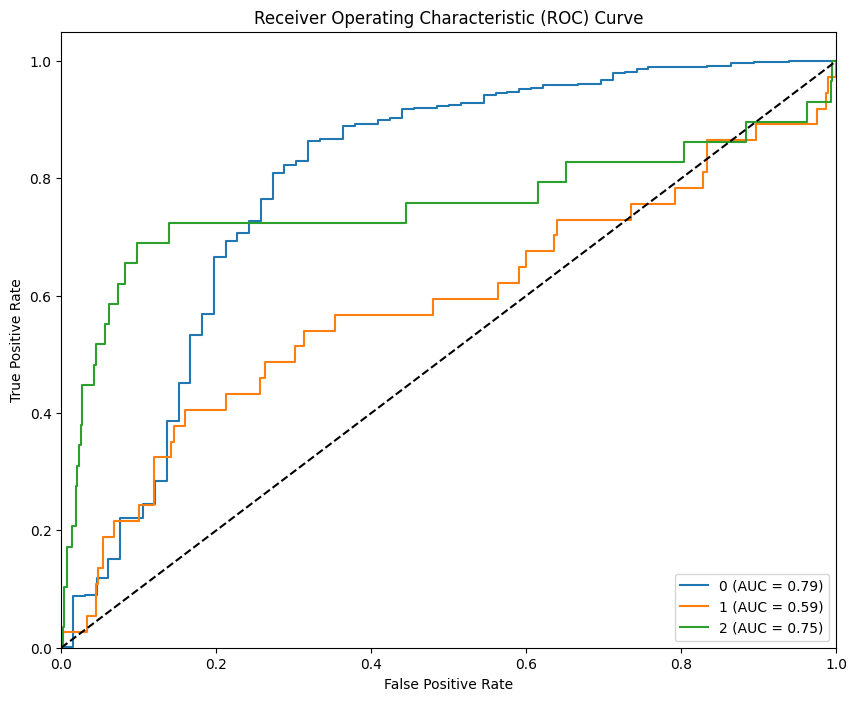

In [87]:
plot_roc_curve(gts_, preds_)

In [49]:
print(classification_report(gts_.argmax(1), preds_.argmax(1)))

              precision    recall  f1-score   support

           0       0.95      0.92      0.93       548
           1       0.22      0.19      0.20        37
           2       0.33      0.59      0.42        29

    accuracy                           0.86       614
   macro avg       0.50      0.56      0.52       614
weighted avg       0.88      0.86      0.86       614

